# 이동평균선
 * 일정 기간동안의 평균을 이동하면서 계산하여 이은 선
 * 5,20,60,120 이 일반적인 기준 
 * 장단기 크로스 포인트 기반의 투자 기법
 * 단기 라인이 장기 라인을 위에서 아래로 뚫었을때 : 매도 타이밍
 * 단기 라인이 장기 라인을 아래서 위로 뚫었을때: 매수 타이밍
 * ? 도대체 몇일 선이 단기라인이고 장기라인인 것인가?
 


In [1]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup as bsp
import matplotlib as mpl
import matplotlib.pyplot as plt
import sqlite3

In [2]:
code=271560
pgno=2
url='https://finance.naver.com/item/sise_day.nhn?code={0}&page={1}'
tgurl=url.format(code,pgno)
tgurl

'https://finance.naver.com/item/sise_day.nhn?code=271560&page=2'

In [3]:
def getDB():
    dbname='hyendei.db'
    with sqlite3.connect(dbname) as conn:
        cur=conn.cursor()
        sql='select * from hyendei order by skey asc'
        qry=cur.execute(sql)
        desc=[row[0] for row in qry.description]
        data=qry.fetchall()
    return((desc,data))

In [4]:
res=getDB()
res[0]

['sidx',
 'skey',
 'sday',
 'sclose',
 'sopen',
 'shigh',
 'slow',
 'svol',
 'syest',
 'splus',
 'sallvol',
 'scom',
 'sfor',
 'scoms']

In [5]:

df=pd.DataFrame(data=res[1],columns=res[0]).set_index('sidx')
df.head()

,skey,sday,sclose,sopen,shigh,slow,svol,syest,splus,sallvol,scom,sfor,scoms
sidx,,,,,,,,,,,,,
3993,20050103,2005-01-03,33550,33850,34400,33400,74311,33800,-250,74311,3280,15530,55501
3992,20050104,2005-01-04,33600,33850,34050,33300,74824,33550,50,74824,-31620,15590,59234
3991,20050105,2005-01-05,35000,33450,35000,33450,108890,33600,1400,108890,44170,12550,52170
3990,20050106,2005-01-06,34400,34800,35300,34400,113929,35000,-600,113929,-20566,19220,94709
3989,20050107,2005-01-07,33000,34300,34800,32750,91600,34400,-1400,91600,-14790,-34900,91600


In [6]:
cdf=df[['sday','sclose']].copy()


In [7]:
cdf.head()

,sday,sclose
sidx,,
3993,2005-01-03,33550
3992,2005-01-04,33600
3991,2005-01-05,35000
3990,2005-01-06,34400
3989,2005-01-07,33000


In [8]:
def mvline(src=[],mday=5):
    mvdata=[0 for i in range(mday-1)]
    mvdata
    tot =len(src)
    for i in range(tot-mday+1):
        mvm=np.mean(cdf['sclose'][i:mday+i])
        mvdata.append(mvm)
    return (mvdata)

In [9]:
def finprs(df):
    fdf=df.copy()
    precre=0 # 이전 주식 잔고
    predeb=1000000 # 이전 통장 잔고
    prestock=0
    for idx,row in fdf.iterrows():
         # 살수 있는 주식의 갯수
        #단기물 곡선이 하위 포지션에 있다가 장기물 곡선을 크로스 하였다=> 주가 상승 압력이 시작됬다
        # 상승할것으로 보여지니 매수한다.
        if (row.loc['shortpos']==1 and row.loc['shortpos']*row.loc['preshortpos']<0):
            canbuy=predeb//row.loc['sclose']
            if(canbuy>0):
                #산다
                cre=precre+canbuy*row.loc['sclose']
                deb=predeb-canbuy*row.loc['sclose']
                instock=canbuy
            else:# 돈없어서 아무일 없다
                instock=prestock
                cre=precre
                deb=predeb                
        # 단기물 곡선이 상위포지션에 있다가 장기물 곡선을 크로스했다--> 주가의 하방압력이 시작됬다.
        # 하락할것으로 보여지니 매도한다.
        elif (row.loc['shortpos']==-1 and row.loc['shortpos']*row.loc['preshortpos']<0):
            cre=0
            deb=predeb+row.loc['sclose']*prestock
            instock=0
            # sellpos:1 prestock:1,sellpos:-1 prestock:0, no debt
        else:# 조건이 안맞아서 아무일 없다.
            instock=prestock
            cre=precre
            deb=predeb
        fdf.loc[idx,'hasstock']=instock
        fdf.loc[idx,'debt']=deb
        fdf.loc[idx,'credit']=cre
        prestock=instock
        precre=cre
        predeb=deb
    return fdf


In [10]:
def optmv(cdf,sv=5,lv=10):
    cdf['mvshort']=mvline(cdf['sclose'],sv)
    cdf['mvlong']=mvline(cdf['sclose'],lv)
    cdf['shortpos']=np.where(cdf['mvshort']>cdf['mvlong'],1,-1) * np.where(cdf['mvlong']==0,0,1)
    redf=cdf.set_index('sday')
    redf['preshortpos']=redf['shortpos'].shift(1)
    rdf=finprs(redf)
    rdf['totval']=rdf['debt']+rdf['credit']
    lastrow=rdf.iloc[-1:]
    mylastval=lastrow['totval'].values[0]
    return ((sv,lv,mylastval))

In [11]:
result=[]
for sb in range(2,20):
    for lb in range(sb+1,sb+60):
        res=optmv(cdf,sb,lb)
        result.append(res)

In [12]:
result

[(2, 3, 597050.0),
 (2, 4, 425800.0),
 (2, 5, 336200.0),
 (2, 6, 198350.0),
 (2, 7, 233800.0),
 (2, 8, 189950.0),
 (2, 9, 320750.0),
 (2, 10, 276300.0),
 (2, 11, 243350.0),
 (2, 12, 222850.0),
 (2, 13, 255300.0),
 (2, 14, 357100.0),
 (2, 15, 421800.0),
 (2, 16, 462350.0),
 (2, 17, 544000.0),
 (2, 18, 755300.0),
 (2, 19, 834800.0),
 (2, 20, 782350.0),
 (2, 21, 599650.0),
 (2, 22, 638100.0),
 (2, 23, 577600.0),
 (2, 24, 600750.0),
 (2, 25, 514650.0),
 (2, 26, 629450.0),
 (2, 27, 613150.0),
 (2, 28, 620050.0),
 (2, 29, 615650.0),
 (2, 30, 506300.0),
 (2, 31, 501400.0),
 (2, 32, 567000.0),
 (2, 33, 595850.0),
 (2, 34, 703550.0),
 (2, 35, 779350.0),
 (2, 36, 720750.0),
 (2, 37, 786200.0),
 (2, 38, 613600.0),
 (2, 39, 782700.0),
 (2, 40, 838100.0),
 (2, 41, 874300.0),
 (2, 42, 837400.0),
 (2, 43, 1035500.0),
 (2, 44, 1040000.0),
 (2, 45, 1153900.0),
 (2, 46, 1053500.0),
 (2, 47, 1023200.0),
 (2, 48, 1012000.0),
 (2, 49, 920000.0),
 (2, 50, 975100.0),
 (2, 51, 1027100.0),
 (2, 52, 943900.0),


In [13]:
rv=optmv(cdf)
rv

(5, 10, 314300.0)

In [14]:
vdf= pd.DataFrame(data=result,columns=["short","long","val"])
vdf.tail()

,short,long,val
1057,19,74,476500.0
1058,19,75,489300.0
1059,19,76,509800.0
1060,19,77,543400.0
1061,19,78,474700.0


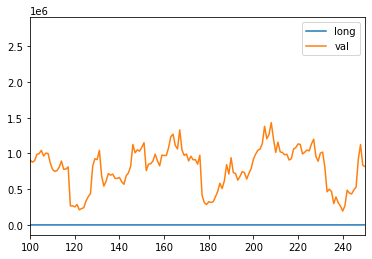

In [15]:
vdf[["long","val"]].plot()
plt.xlim(100,250)
plt.show()

In [16]:
vdf[["val"]].max()
maxrow=vdf.loc[vdf["val"]==2767850.0]
maxrow

,short,long,val
557,11,38,2767850.0


In [17]:
ax1=cdf['totval'].plot()
ax1.set_ylabel('debit')
ax2 = cdf['sclose'].plot(secondary_y=True, color='r')
ax2.set_ylabel('stock price')
plt.show()

KeyError: 'totval'

In [ ]:
df

In [ ]:
df.to_csv('profit_hyendei.csv')

In [ ]:
import mpl_finance as mpf

In [ ]:
from mpl_finance import candlestick2_ohlc
cdf = df.set_index('sday')
candf=cdf[['sopen','shigh','slow','sclose']].astype(int)

In [ ]:
x=np.arange(len(candf.index))
xs=np.reshape(x,(-1,1))
xs

In [ ]:
ohlc=candf.values
ohlc
canohlc=np.hstack((xs,ohlc))
canohlc

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
candlestick_ohlc(ax,canohlc,width=0.5,colorup='r',colordown='b')
plt.xlim(10,20)
#plt.ylim()
plt.show()